# House Prices - Advanced Regression Techniques

## Deva Kulkarni, Jared Dec, Marc Semonick, Trevor Johnson

## December 2021

<br>

The following report is based on the Kaggle competition: ["House Prices - Advanced Regression Techniques"](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).  In the competition, participants are challenged to predict housing prices in Ames, Iowa based on a dataset complied by [James DeCock](https://http://jse.amstat.org/v19n3/decock.pdf).  The dataset contiains detailed data houses sold in Ames, Iowa between the years 2006 and 2010.  There are up to 80 data points per house, including expected hard data such as square feet for each floor and lot size, as well as some more subjective data like quality and condition.  The **inference problem** that we will attempt to solve in this report is: 

<p style="text-align: center;">Given these data points for a house, predict the sale price of that house.</p>

To guide the reader through our solution to this inference problem, we will divide our approach into three main sections: Exploratory data analysis, feature engineering and model exploration, and our final predictive model.  The final deliverables will be this notebook containing all relevant code and descriptions, as well as a .csv output of our final predictions as required by the Kaggle competition.

# Setups

Import modules.

In [1]:
import os 
import re

# data manipulation/viz
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# modeling setups
from patsy import dmatrices
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.preprocessing import StandardScaler

# linear modeling
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
import statsmodels.api as sm
from statsmodels.formula.api import glm 
from sklearn.linear_model import LogisticRegression

# tree modeling
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# other
from sklearn.decomposition import PCA
from keras.layers import Dense, Activation
from keras.models import Sequential
from sklearn.model_selection import train_test_split

#K-Fold cross-validation
from numpy import mean
from numpy import std
from numpy import absolute
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn import metrics

# turn off the df['col'] = x assignment warning
pd.options.mode.chained_assignment = None  # default='warn'

Read in data.

In [2]:
train = pd.read_csv("../../housing_data/train.csv")
test = pd.read_csv("../../housing_data/test.csv")
sample = pd.read_csv("../../housing_data/sample_submission.csv")

Creating functions to clean the data so it could theoretically be used on any new unforeseen data.

The na_clean function handles the missing values we've encountered in the data. A few variables such as `PoolQC` and `MiscFeature` had so many missing values that we decided to remove the variable entirely from the dataset. Several other variables had fewer missing values that we've decided to deal with in various ways such as median replacement, zero replacement, or by filling with "missing". 

The standard_feature_eng function simplifies several variables and creates new ones based on the existing variables. We've commented each computation in both functions to explain each step. 

In [3]:
def na_clean(df):
    
    # some vars are just too missing so I remove the field
    df = df.drop(columns = ["PoolQC", "MiscFeature"])

    # replace some numeric vars w/ median
    median_replace_vars = ['LotFrontage', 'MasVnrArea', 'GarageYrBlt', 'BsmtFinSF1', 'BsmtFinSF2', 
        'BsmtUnfSF', 'TotalBsmtSF', 'GarageArea']
    for var in median_replace_vars:
        df[var].fillna(df[var].median(), inplace = True)
    
    # replace some num vars w/ 0
    zero_replace_vars = ['BsmtFullBath', 'BsmtHalfBath', 'GarageCars']
    for var in zero_replace_vars:
        df[var].fillna(0, inplace = True)
    
    # replace some cat vars w/ most freq value 
    df['MasVnrType'].fillna('None', inplace = True)
    df['Electrical'].fillna('SBrkr', inplace = True)
    df['MSZoning'].fillna('RL', inplace = True)
    df['SaleType'].fillna('WD', inplace = True)
    df['Utilities'].fillna('AllPub', inplace = True)
    df['KitchenQual'].fillna('TA', inplace = True)
    df['Functional'].fillna('Typ', inplace = True)

    # other cat vars just put missing if there isn't a glaring most popular category
    replace_missing_vars = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
        'BsmtFinType2', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'Fence', 'Exterior1st', 
        'Exterior2nd', 'FireplaceQu']
    for var in replace_missing_vars:
        df[var].fillna("Missing", inplace = True)

    return df



# Function for some standard feature engineering to use in all models
def standard_feature_eng(df, test_data = False):
    '''Input either the training or test data. 
    2nd arg set to True if it's the testing data. That way we ignore the final log transformation on sale price'''

    # num features to just binarize b/c few houses have the feature
    df["SwimmingPool"] = df['PoolArea'].map(lambda x: 0 if x==0 else 1)
    df["3SsnPorch"] = df['3SsnPorch'].map(lambda x: 0 if x==0 else 1)
    df["ScreenPorch"] = df['ScreenPorch'].map(lambda x: 0 if x==0 else 1)

    # re-factoring vars:
    # group the irregularities into 2 factor levels
    df['LotShape'] = df['LotShape'].map({'Reg': 'Reg', 'IR1': 'Reg', 'IR2': 'Irreg', 'IR3': 'Irreg'})

    # simplifying MSSubClass because we have the year built in another feature
    df['MSSubClass'] = df['MSSubClass'].map(lambda x: 
        "1_story"   if (x in (20, 30, 40, 120)) else(
        "1.5_story" if (x in (45, 50, 150)) else(
        "2_story"   if (x in (60, 70, 75, 160, 180, 190)) else(
        "split"     if (x in (80, 85)) else(
        "duplex"    if (x ==90) else(
        "other"))))))
    df['MSSubClass'] = df['MSSubClass'].astype("object")

    # simplifying more vars
    # electrical:
    df['Electrical'] = df['Electrical'].map(lambda x: "SBrkr" if x == "SBrkr" else "Fuse")
    # exterior:
    df['Exterior'] = df['Exterior1st'].map(lambda x: 
        # group exterior into simplified var based on average prices
        "Expensive" if (x in ("VinylSd", "CemntBd", "Stone", "ImStucc")) else(
        "Cheap" if (x in ("BrkComm", "AsphShn", "CBlock", "AsbShng")) else(
        "Moderate")))
    df = df.drop(columns=['Exterior1st', 'Exterior2nd'])
    # garage
    df['GarageQual'] = df['GarageQual'].map(lambda x: 
        # group exterior into simplified var based on average prices
        "Good" if (x in ("Ex", "Gd")) else(
        "Medium" if (x in ("TA")) else(
        "Bad")))
    df['Heating'] = df['Heating'].map(lambda x: "Gas" if x in ("GasA", "GasW") else "Other")

    # deciding to drop a few features for various reasons
    vars_to_drop = [
        # not much variation:
        "LowQualFinSF", 
        "LandSlope", 
        "MiscVal", 
        "RoofMatl",
        "Condition2",
        #"KitchenAbvGr" # hardly any variation. But, Deva included in lm's so including it now.
        "PoolArea", # binarized above
        "Utilities", # only 1 obs in training data different from regular
        "HouseStyle" # already explained in other vars
        ]
    df.drop(columns=vars_to_drop, inplace=True) 

    # adding a remodeled feature
    df['Remodeled'] = (df.YearRemodAdd-df.YearBuilt) == 0

    # total inside area will be a sum of 1st and 2nd floor sq ft
    df['Total_Inside_Area'] = df['1stFlrSF'] + df['2ndFlrSF']
    df.drop(columns = ['1stFlrSF', '2ndFlrSF', 'GrLivArea'], inplace = True)

    # simplify the bathrooms variable
    df['Bathrooms'] = df.BsmtFullBath + 0.5*df.BsmtHalfBath + df.FullBath + 0.5*df.HalfBath
    df.drop(columns = ['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath'], inplace = True)

    # get log of sale price which will be our actual response variable
    if test_data:
        pass 
    else:
        
        df['LogSalePrice'] = np.log(df.SalePrice)

    return df


# EDA

See size of the data and check for missing values.

In [4]:
print("Train shape: {}".format(train.shape))
print("Test shape: {}".format(test.shape))
print("\nFeature with missing values:")
train.isnull().sum()[train.isnull().sum() != 0]

Train shape: (1460, 81)
Test shape: (1459, 80)

Feature with missing values:


LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

The response variable, Sale Price, is skewed right with most homes priced between \$100K and \$200K. After taking the log of the Sale Price, the distribution is normally distributed. 

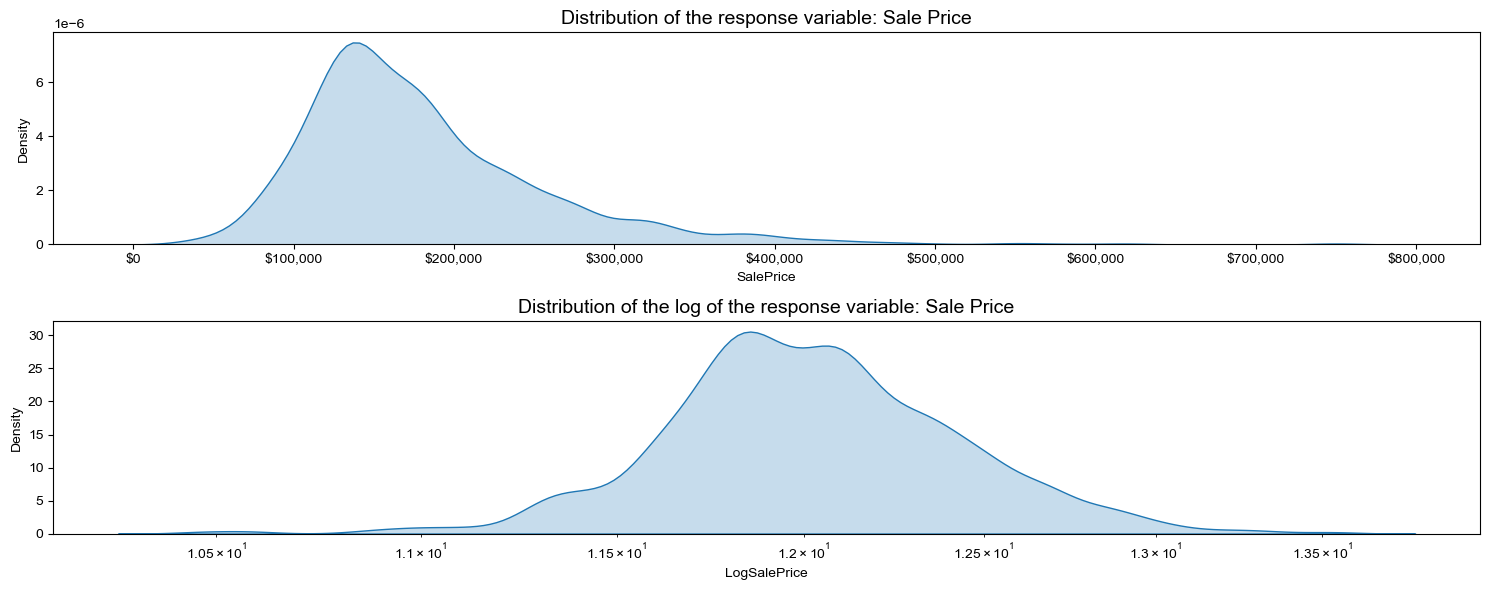

In [24]:
train_log = train.copy()
train_log['LogSalePrice'] = np.log(train_log['SalePrice'])

fig, ax = plt.subplots(2, 1, figsize=(15, 6))
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(ax=ax[0], data=train, x="SalePrice", bw_adjust=.8, fill=True)\
    .set_title("Distribution of the response variable: Sale Price", size=14)

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax[0].xaxis.set_major_formatter(tick)

sns.kdeplot(ax=ax[1], data=train_log, x="LogSalePrice", bw_adjust=.8, fill=True, log_scale=True)\
    .set_title("Distribution of the log of the response variable: Sale Price", size=14)

ax[1].xaxis.set_major_formatter(tick)

fig.tight_layout()

The plot below shows the variables that have a correlation above 0.7 with at least one other variable. Many variables are highly correlated with Sale Price such as square feet variables, year built, the number of bedrooms above ground, and garage size. 

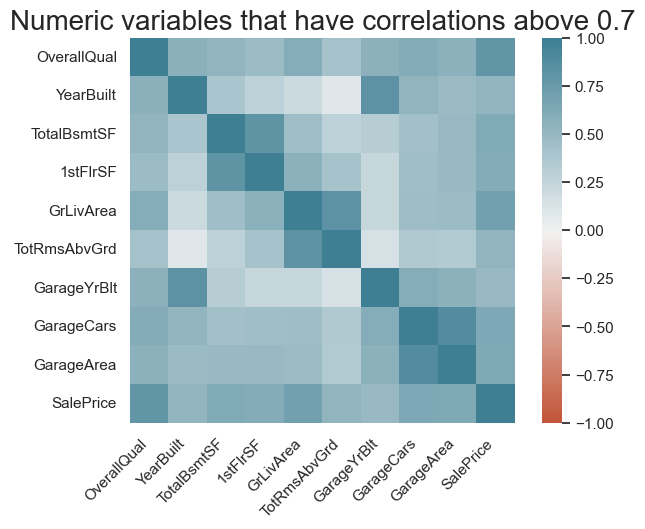

In [25]:
# get correlations of all numeric vars
corr_orig = train.select_dtypes(include=['float', 'int']).corr()

# there are 38 of them, let's look at a subset to only show the ones w/ correlations above some threshold
threshold = .7
bool_list = [sum((corr_orig.iloc[i,:] < 1) & (np.abs(corr_orig.iloc[i,:]) > threshold)) > 0 for i in range(corr_orig.shape[0])]
corr = train.loc[:, (train.dtypes == type(1.0)) | (train.dtypes == type(1))].loc[:, bool_list].corr()

# plot the results
sns.set()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
ax.set_title("Numeric variables that have correlations above {:.1f}".format(threshold), fontdict = {"fontsize": 20})

plt.gcf().set_size_inches(7, 5)
fig.tight_layout()
print("")

The grid below shows every numeric feature's relationship to the Sale Price. Like the correlation plot above confirms, several variables that represent the square footage of the home have a clear positive relationship with Sale Price. The overall quality of the home also appears to have a strong positive relationship. 

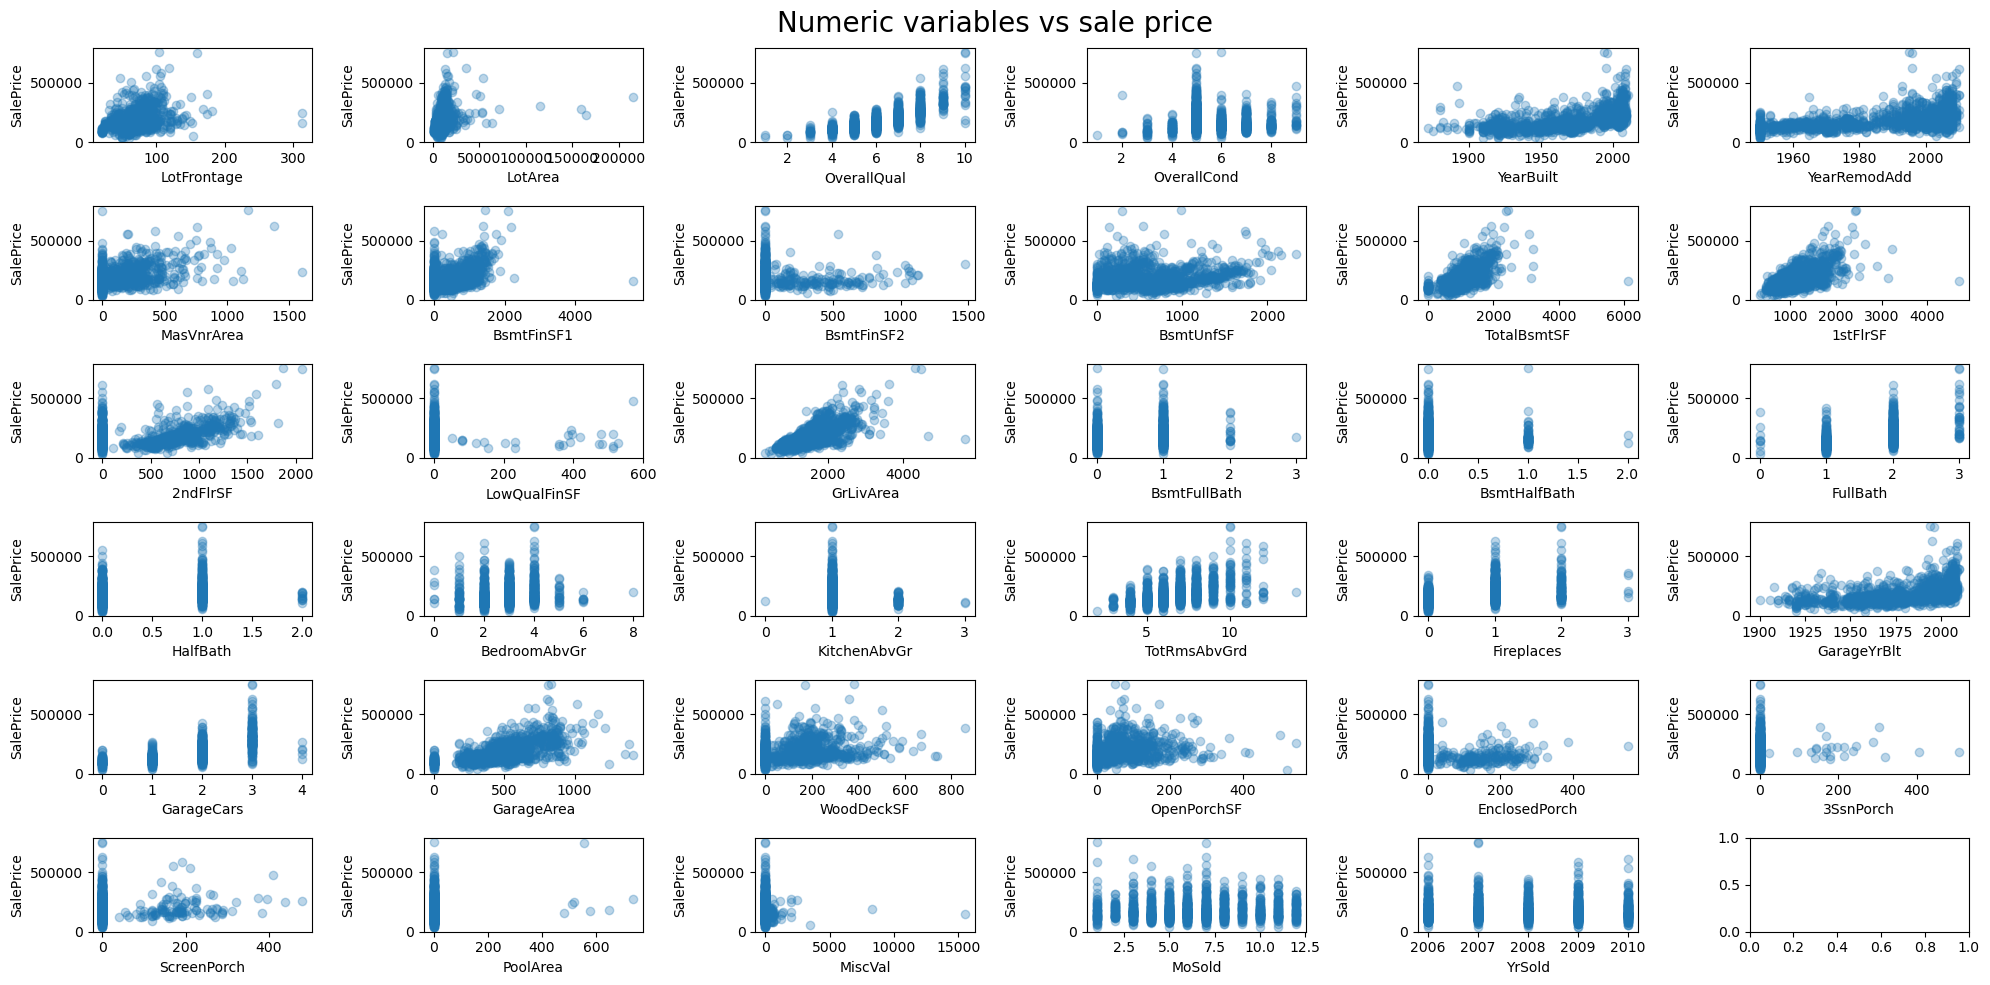

In [26]:
# create dataset for plotting
plot_df = train.drop(columns = ["PoolQC", "MiscFeature", "Id"])
plot_df['MSSubClass'] = plot_df['MSSubClass'].astype('object')

# scatter plots of all num vars w/ response var
num_vars = plot_df.select_dtypes(include=['float', 'int'])

# plot in 6x6 grid to plot the 36 num vars against SalePrice
num_rows = 6
num_cols = 6
plt.style.use('default')
fig, ax = plt.subplots(num_rows, num_cols, figsize = (20, 10))

col_i = 0
for i in range(num_rows):
    for j in range(num_cols):
        if (num_vars.columns[col_i] == "SalePrice"):
            pass 
        else:
            ax[i][j].scatter(num_vars.iloc[:, col_i], num_vars['SalePrice'], alpha = .3)
            ax[i][j].set_xlabel(num_vars.columns[col_i])
            ax[i][j].set_ylabel("SalePrice")
            
            col_i += 1

fig.suptitle("Numeric variables vs sale price".format(col_i), size=20)
fig.tight_layout()
print("")

The next grid shows every categorical feature's relationship to the Sale Price of the home. Each bar shows the average sale price for each factor level of the categorical feature. Several features provide a lot of separation of Sale Price such as MSZoning, neighborhood, condition 1 & 2, and quality variables. 

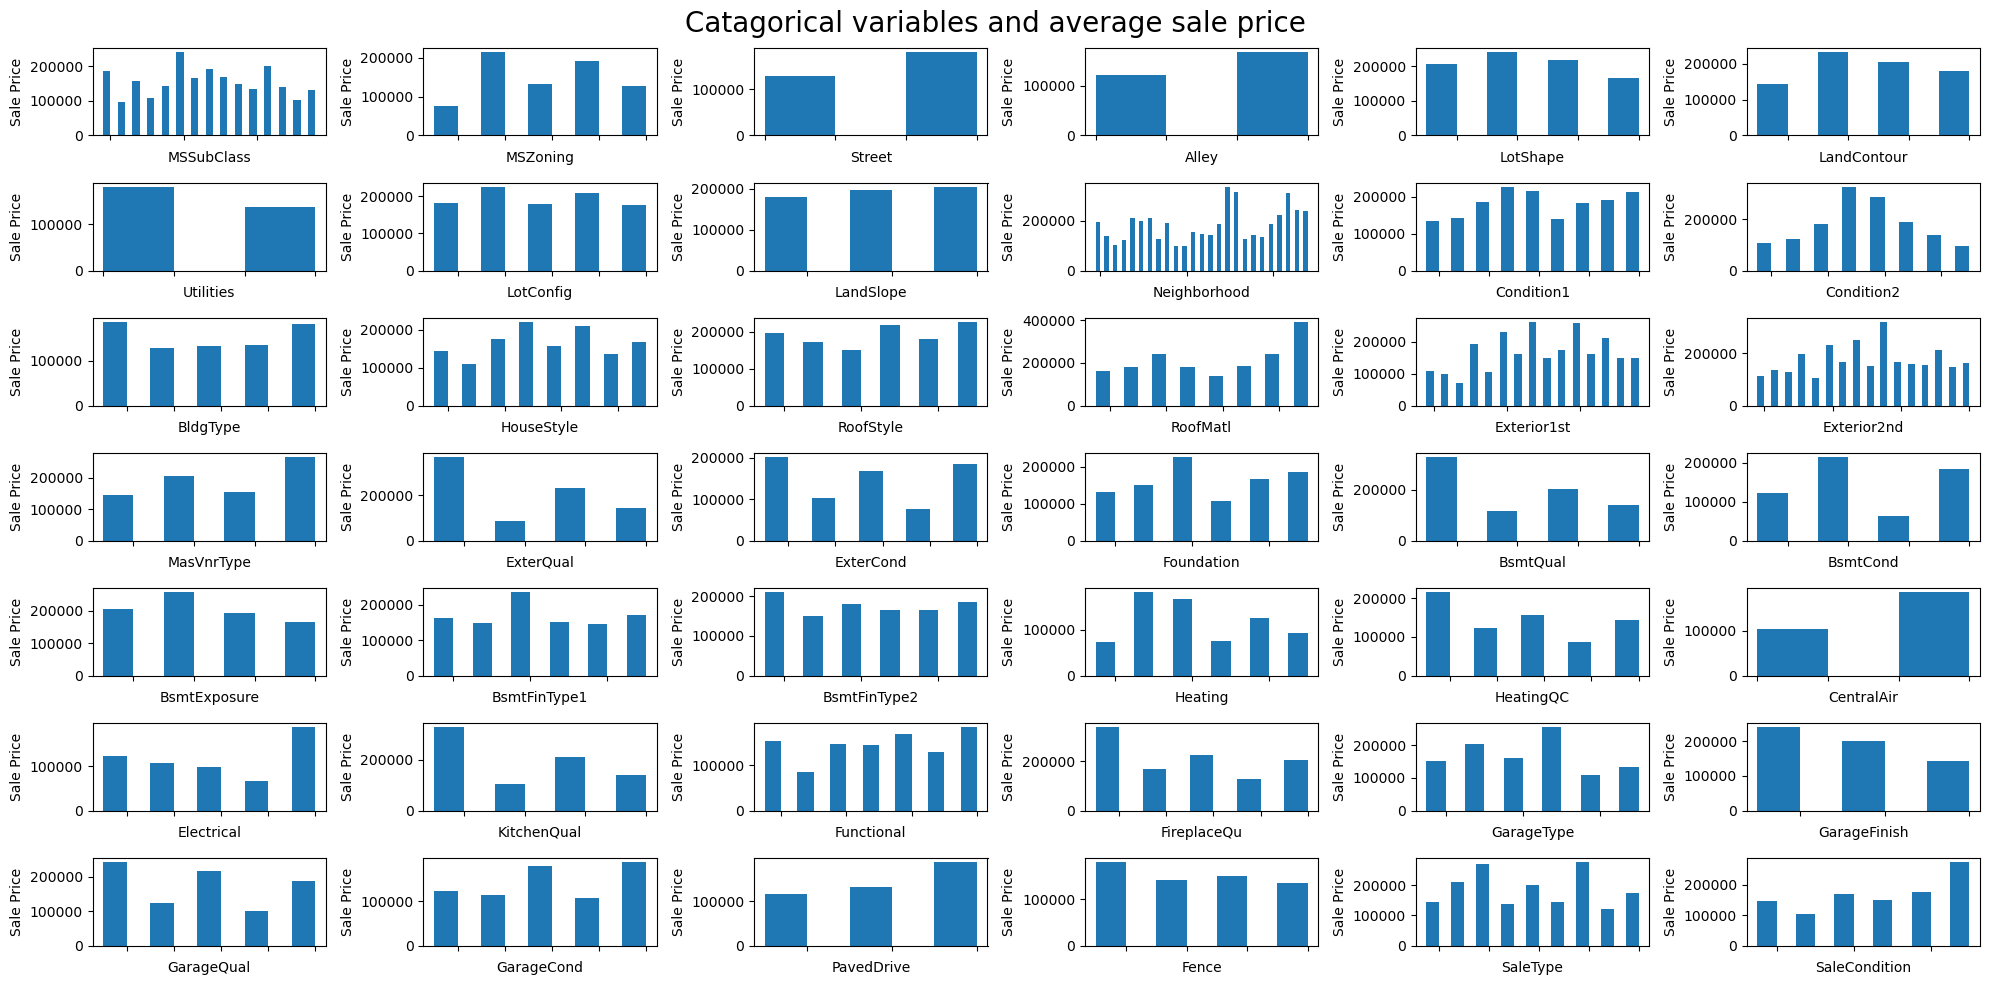

In [27]:
# categorical exploration
cat_vars = pd.concat([plot_df.select_dtypes("object"), train.SalePrice], axis = 1)
n_cols = cat_vars.shape[1]

# plots
num_row = 7
num_col = 6
fig, ax = plt.subplots(num_row, num_col, figsize = (20, 10))

count_k = 0
for i in range(num_row):
    for j in range(num_col):

        # each df
        var_i = cat_vars.columns[count_k]

        if var_i == "SalePrice":
            pass 
        else:

            df_i = pd.DataFrame(cat_vars.groupby(var_i)['SalePrice'].mean())
            df_i.reset_index(inplace = True)

            # create plot i
            x = np.arange(df_i.shape[0])
            width = .5

            # set the bars
            ax[i][j].bar(x - width / 2, df_i.SalePrice, width, label = "x")
            ax[i][j].set_xlabel(var_i)
            ax[i][j].set_ylabel("Sale Price")
            #ax[i][j].set_xticklabels(df_i[var_i], rotation = 90)
            ax[i][j].set_xticklabels("")
            
            count_k += 1

fig.suptitle("Catagorical variables and average sale price", size=20)
fig.tight_layout()

print("")

The histogram below shows the distribution of the home sale price divided by lot area. Most houses are priced between \$10 and \$30 per square foot of lot area. There is also an interestng tail extended on the right side of the plot of houses that seem to have a higher price per square feet than most of the other houses. Digging a little deeper into these, it seems like these houses are likely to be in certain neighborhoods.

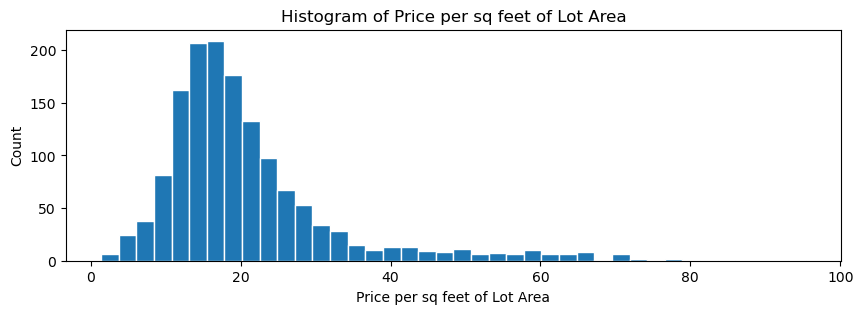

In [28]:
# Looking at price per sq feet of lot area
plot_df.loc[:, 'PricePerSqFeet'] = plot_df.SalePrice/train.LotArea

fig, ax = plt.subplots(figsize = (10, 3))

ax.hist(plot_df.PricePerSqFeet, bins = 40, edgecolor = "white")
ax.set_ylabel('Count')
ax.set_xlabel('Price per sq feet of Lot Area')
ax.set_title('Histogram of Price per sq feet of Lot Area')
print("")

In [29]:
# Looking at the Neighborhoods of houses that are in the extended tail of the histogram
print('Neighborhoods for houses with high price per sq feet')
print(plot_df[plot_df.PricePerSqFeet>40][['Neighborhood']].value_counts())
print('')

# Looking at the Neighborhoods of houses that are in the normal part of the histogram
print('Neighborhoods for houses with low price per sq feet')
print(plot_df[plot_df.PricePerSqFeet<40][['Neighborhood']].value_counts())

Neighborhoods for houses with high price per sq feet
Neighborhood
Somerst         27
Blmngtn         17
BrDale          16
NridgHt         13
MeadowV         11
StoneBr         11
NPkVill          5
Edwards          4
Crawfor          3
Blueste          2
NoRidge          2
ClearCr          1
CollgCr          1
NAmes            1
OldTown          1
dtype: int64

Neighborhoods for houses with low price per sq feet
Neighborhood
NAmes           224
CollgCr         149
OldTown         112
Edwards          96
Gilbert          79
Sawyer           74
NWAmes           73
NridgHt          64
Somerst          59
SawyerW          59
BrkSide          58
Mitchel          49
Crawfor          48
NoRidge          39
Timber           38
IDOTRR           37
ClearCr          27
SWISU            25
StoneBr          14
Veenker          11
MeadowV           6
NPkVill           4
dtype: int64


# Ideas based on EDA

### Complexity Analysis

To look at the effect of the number of features on the scores of fit and generalize steps, we use a simple OLS regression model. From the plot, we do see that as we keep adding features, the score on the fit data keeps increasing , but the score on the generalize data peaks at some point and then starts decreasing.

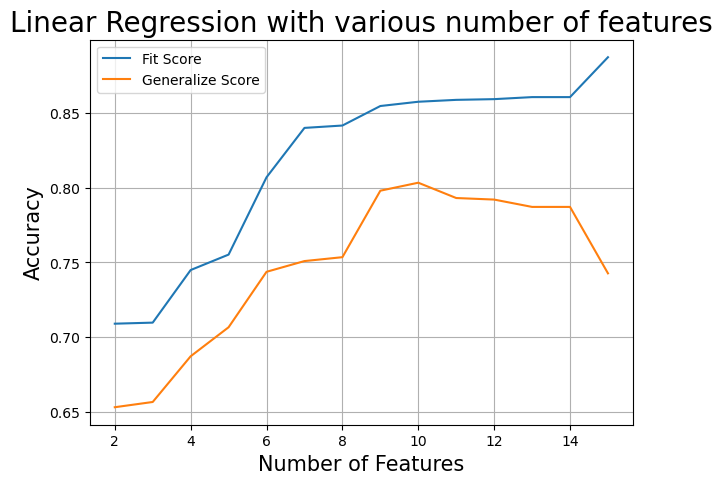

In [11]:
# Prepare data for Linear Regrssion
train_subset = standard_feature_eng(na_clean(train))[['Id', 'LotArea', 'Street', 'Neighborhood', 'OverallQual', 'OverallCond','YearBuilt', 
                      'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'YrSold', 'MoSold',
                     'SalePrice','Remodeled', 'Total_Inside_Area','Bathrooms',  
                      'LogSalePrice']][:1120]

dev_subset = standard_feature_eng(na_clean(train))[['Id', 'LotArea', 'Street', 'Neighborhood', 'OverallQual', 'OverallCond','YearBuilt', 
                      'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'YrSold', 'MoSold',
                     'SalePrice','Remodeled', 'Total_Inside_Area','Bathrooms', 
                      'LogSalePrice']][1120:]

# Some basic Feature Engineering
train_subset['Expensive'] = train_subset.LogSalePrice > 12
dev_subset['Expensive'] = dev_subset.LogSalePrice > 12

def Categorize_Month(df):
    df['MoSold'] = df['MoSold'].map(str)
    return df

def Change_Kitchen_Qual(df):
    ''' This function converts the kitchen quality levels to numberica values'''
    kitchen_qual_dict = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1}
    return df.replace({'KitchenQual': kitchen_qual_dict})

train_subset_LR = Change_Kitchen_Qual(Categorize_Month(train_subset))
dev_subset_LR = Change_Kitchen_Qual(Categorize_Month(dev_subset))

# The feature used in the complexity Analysis
cols = ['LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'KitchenQual', 'TotRmsAbvGrd', 
       'Total_Inside_Area','KitchenAbvGr',
        'Expensive', 'Bathrooms' , 'MoSold',
        'YrSold', 'BedroomAbvGr', 'Remodeled', 
         'Neighborhood', 'Street']
Complexity = []
Fit_Score = []
Gen_Score = []

# Createing a Linear regression with various number of features
for i in range(2, len(cols)):
    reg = LinearRegression()
    reg.fit(pd.get_dummies(train_subset_LR[cols[:i]]), train_subset_LR['LogSalePrice'])
    Fit_Score.append(reg.score(pd.get_dummies(train_subset_LR[cols[:i]]), train_subset_LR['LogSalePrice']))

    if 'Neighborhood' in cols[:i]:
        dev_subset_LR_Special = pd.get_dummies(dev_subset_LR[cols[:i]])
        dev_subset_LR_Special['Neighborhood_Blueste'] = False
        Gen_Score.append(reg.score(dev_subset_LR_Special, dev_subset_LR['LogSalePrice']))

    else:
        Gen_Score.append(reg.score(pd.get_dummies(dev_subset_LR[cols[:i]]), dev_subset_LR['LogSalePrice']))
    
    #Complexity.append(pd.get_dummies(train_subset_LR[cols[:i]]).shape[1])
    Complexity.append(i)
    

fig = plt.figure(figsize = (7,5))
ax = fig.add_subplot(1,1,1)
ax.plot(Complexity, Fit_Score, label = 'Fit Score')
ax.plot(Complexity, Gen_Score, label = 'Generalize Score')
ax.set_xlabel('Number of Features', fontsize = 15)
ax.set_ylabel('Accuracy', fontsize = 15)
ax.set_title('Linear Regression with various number of features', fontsize = 20)
ax.legend()
ax.grid()


### Error analysis of Initial Lasso Model

During the initial modeling stage, we found that a Lasso regression model performed well in terms of accuracy in the generalize step. In order to refine it's performance, we investigate the predictions made by the Lasso model and performed error analysis. Specifically, we look at the percentage error in the log of predicted house price comapred to the log of actual house price.

Lasso alpha is equal to:  0.0001
Mean MAE: 0.094 (0.010)
Accuracy: 0.8829996340075951


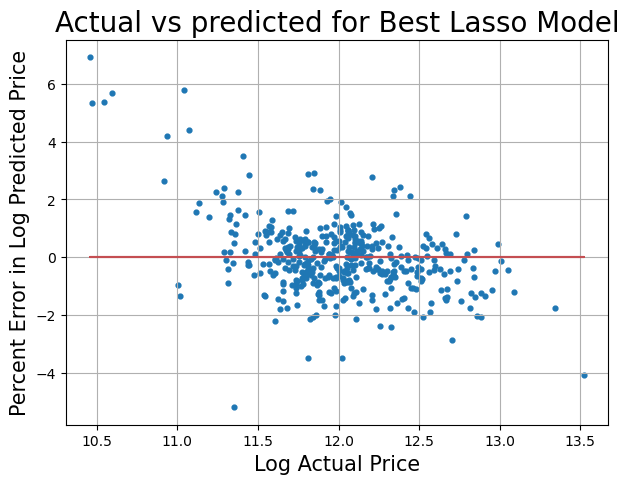

In [13]:
df_initial_lasso = standard_feature_eng(na_clean(train))

# preprocess the data
train_dummies = pd.get_dummies(df_initial_lasso)

# create the train and test splits
dev_train, dev_test = train_test_split(train_dummies, test_size=0.3, random_state=1)

#Best value of Alpha for Lasso
for i in [0.0001]:

    model = Lasso(alpha = i, tol = 0.0001, max_iter = 5000)

    # Fit Lasso Model
    model.fit(dev_train.drop(columns = ["SalePrice", 'LogSalePrice', 'Id']), dev_train.LogSalePrice)
    
    RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

    # calculate scores
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, dev_train.drop(columns = ["SalePrice", 'LogSalePrice', 'Id']), 
                             dev_train.LogSalePrice, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

    scores = absolute(scores)

    # calculate MAE, accuracy.
    print("Lasso alpha is equal to: ", i)
    print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))
    print('Accuracy:', model.score(dev_test.drop(columns = ["SalePrice", 'LogSalePrice', 'Id']), dev_test.LogSalePrice))
    
# Make predictions
dev_predict = model.predict(dev_test.drop(columns = ["SalePrice", 'LogSalePrice', 'Id']))

# Plot
fig = plt.figure(figsize = (7,5))
ax = fig.add_subplot(1,1,1)
ax.scatter(dev_test.LogSalePrice, (dev_predict-dev_test.LogSalePrice)/dev_test.LogSalePrice*100, s = 12)
ax.plot(dev_test.LogSalePrice, np.zeros(len(dev_test.LogSalePrice)), 'r')
ax.set_xlabel('Log Actual Price', fontsize = 15)
ax.set_ylabel('Percent Error in Log Predicted Price', fontsize = 15)
ax.set_title('Actual vs predicted for Best Lasso Model', fontsize = 20)
ax.grid()


From the plot, we see that there are a fair number of houses that have a low actual price for which the model has a high percentage error. Specifically, it tends to predict a higher price for these houses. To dig a little deeper, we look into these houses to see if we can find any patterns. From looking at the houses with maximum percentage errors in predictions (> 4%), we see that these are houses that have a low overall condition, are very old and have a large number of rooms. The actual sale price of these houses is quite low, bu the model tends to make predictions that are higher. It is likely that the large number of rooms might be the cause for this error. We looked at various methods to separate cheap houses from expensive ones as discussed below, however, we got the best score on the inference problem with the simple Lasso model.

In [14]:
# Calculate error in predictions
fraction_error = (dev_predict-dev_test.LogSalePrice)/dev_test.LogSalePrice

# Subset data frame with few columns; and rows high error
dev_test_with_error = pd.concat([dev_test, fraction_error.rename('fraction_error')], axis = 1)
dev_test_with_max_error = dev_test_with_error[(dev_test_with_error.fraction_error) > .04].loc(axis=1)['OverallCond', 'YearBuilt', 
                                                                                      'TotRmsAbvGrd', 'SalePrice', 
                                                                                  'fraction_error'].sort_values(by 
                                                                                            = ['fraction_error'])

print(dev_test_with_max_error.to_string(index=False))

 OverallCond  YearBuilt  TotRmsAbvGrd  SalePrice  fraction_error
           5       1952             4      55993        0.041819
           6       1927             5      64500        0.043958
           3       1949             4      35311        0.053509
           6       1910             6      37900        0.053613
           4       1920             6      40000        0.056736
           5       1965             5      62383        0.057706
           5       1920             4      34900        0.069178


### Dividing cheap neighborhoods from expensive neighborhoods

Early on in the error analysis process, it was discovered by our team that our model was poor at predicting prices for houses that tended to be older or cheaper. An early idea for how to separate our data by characteristics like age and price was to separate houses in the data from poor, older neighborhoods with houses in newer neighborhoods that tended to be owned by the more wealthy. Based on exploratory data analysis there is quite a bit of variation between the neighborhoods in the dataset in terms of price, age, and as a result, price per square foot. 

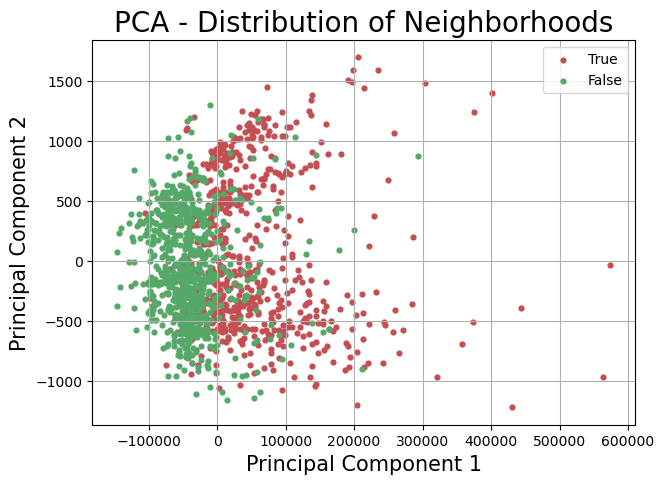

In [15]:
train_2 = standard_feature_eng(na_clean(train))
# additional data cleaning
for x in range(len(train_2.TotalBsmtSF)):
    if train_2['TotalBsmtSF'][x] ==0:
        train_2['TotalBsmtSF'][x] = 1
    
train_2.Total_Inside_Area = np.log(train_2.Total_Inside_Area)
train_2.TotalBsmtSF = np.log(train_2.TotalBsmtSF)
train_2.LotArea = np.log(train_2.LotArea)

Expensive_neighborhoods = ['NoRidge', 'StoneBr', 'NridgHt','Timber','Veenker','Somerst', 'ClearCr','CollgCr','Blmngtn','Gilbert','NWAmes', 'SawyerW']
train_2['Expensive_neighborhood'] = train_2['Neighborhood'].apply(lambda x: any([k in x for k in Expensive_neighborhoods]))

for i in train_2:
    if train_2[i].dtype=='object':
        train_2 = train_2.drop(i,axis=1)
        
#train_2.info()
train_2 = train_2[(train_2['Total_Inside_Area']<8.2) | (train_2['SalePrice']>200000)]
train_3 = standard_feature_eng(na_clean(train))
train_3 = train_3[(train_3['Total_Inside_Area']<np.exp(8.2)) | (train_3['SalePrice']>200000)]

pca = PCA(n_components=2)
two_dimension_components = pca.fit_transform(train_2)

#print(two_dimension_components.components_)
pca_temp = np.column_stack((two_dimension_components,train_3['Neighborhood']))
pca_df = pd.DataFrame(data = pca_temp, columns =["pc1", "pc2", "Neighborhood"])
fig = plt.figure(figsize = (7,5))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('PCA - Distribution of Neighborhoods', fontsize = 20)

#Expensive_neighborhoods = ['Somerst', 'Blmngtn', 'BrDale', 'NridgHt', 'StoneBr', 'MeadowV']
Expensive_neighborhoods = ['NoRidge', 'StoneBr', 'NridgHt','Timber','Veenker','Somerst', 'ClearCr','CollgCr','Blmngtn','Gilbert','NWAmes', 'SawyerW']
pca_df['Expensive_neighborhood'] = pca_df['Neighborhood'].apply(lambda x: any([k in x for k in Expensive_neighborhoods]))
temp_axis = [pca_df['Expensive_neighborhood'].unique()]
targets = temp_axis[0]
colors = ['r','g']

for target, color in zip(targets,colors):
    # assign a color to each observation based on its outcome
    indicesToKeep = pca_df['Expensive_neighborhood'] == target
    # scatter with pca1 assigned to x-axis, pca2 assigned to y axis
    # color set based on assignment which was specified earlier.
    ax.scatter(pca_df.loc[indicesToKeep, 'pc1']
            , pca_df.loc[indicesToKeep, 'pc2']
            , c = color, s = 12)
ax.legend(targets)
ax.grid()



In this PCA: SalePrice is the predominant variable in Principal Component 1 (along the x-axis), and the green dots represent neighborhoods that have houses with lower prices per square foot while the red dots represent neighborhoods that have houses with high prices per square foot on average. As one can see, the data appears to visually separable but models that naively flagged houses as being in neighborhoods that were labelled as older and cheaper per square foot and those that were in newer neighborhoods with high costs per square foot, actually performed worse than models where the houses were not separated in such a manner. It appears, as a result that the sale price of houses depend on many factors other than the general characteristics of the neighborhoods in which they are located.

### PCA without SalePrice for Expensive vs Cheap houses

Another method that we attempted to separate cheap from expensive houses was to use PCA without the SalePrice varaible, with the aim that the data may be separable using only the dependent features and we may amke use of this separation to build different models for cheap and expensive houses and use these for predictions. 

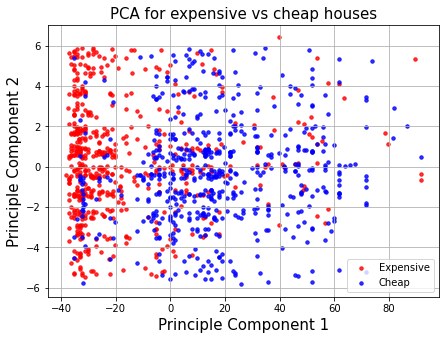

In [6]:
# Subset only some intuitively useful features and some more feature engineering
train_subset_PCA = standard_feature_eng(na_clean(train))[['LotArea', 'OverallQual', 'OverallCond','YearBuilt', 
                      'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'YrSold', 'MoSold',
                     'SalePrice','Remodeled', 'Total_Inside_Area','Bathrooms']][:1120]

train_subset_PCA['LotArea'] = np.log(train_subset_PCA.LotArea)
train_subset_PCA['Total_Inside_Area'] = np.log(train_subset_PCA.Total_Inside_Area)

def Change_Kitchen_Qual(df):
    ''' This function converts the kitchen quality levels to numberical values'''
    kitchen_qual_dict = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1}
    return df.replace({'KitchenQual': kitchen_qual_dict})

train_subset_PCA = Change_Kitchen_Qual(train_subset_PCA)


# Perform PCA
pca = PCA(n_components=2)
train_data_transformed = pca.fit_transform(train_subset_PCA.drop(['SalePrice'], axis=1))

# Plot
fig = plt.figure(figsize = (7,5))
ax = fig.add_subplot(1,1,1)

# Expensive houses, LogSalePrice > 12
ax.scatter(train_data_transformed[:,0][np.log(train_subset_PCA.SalePrice) > 12], 
           train_data_transformed[:,1][np.log(train_subset_PCA.SalePrice) > 12], 
           c = 'r', s = 12, label = 'Expensive', alpha = 0.8)

# Cheap houses, LogSalePrice < 12
ax.scatter(train_data_transformed[:,0][np.log(train_subset_PCA.SalePrice) < 12], 
           train_data_transformed[:,1][np.log(train_subset_PCA.SalePrice) < 12], 
           c = 'b', s = 12, label = 'Cheap', alpha = 0.8)

ax.set_xlabel('Principle Component 1', fontsize = 15)
ax.set_ylabel('Principle Component 2', fontsize = 15)
ax.set_title('PCA for expensive vs cheap houses', fontsize = 15)
ax.legend()
ax.grid()



In this PCA: We do see that there is some separation between the expensive houses and the cheap houses. The expensive houses tend to cluster on the left of the graph and have a low value for the first Principle Component. However, there is still substantial overlap between the two clusters, hence we do not proceed with using PCA for separating the expensive houses from the cheap houses.

### Logistic Regression to Classify houses

Another attempt we made to classify houses as cheap and expensive was using logistic regression. We created a threshold for cheap and expensive and added this as a label to the fit data set. We then used logistic regression to classify the generalize data set and saw that the performance for this classification was fairly good. We then used two separate Lasso models for cheap and expesive houses based on this calssification. However, the lasso regressions for each group perform very poorly and the simple lasso regression for the whole group performs much better.

In [17]:
# Getting data ready for Logistic regression and do feature engineering

train_subset_LGR = standard_feature_eng(na_clean(train))[['LotArea', 'OverallQual', 'OverallCond','YearBuilt', 
                      'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'YrSold', 'MoSold',
                     'SalePrice','Remodeled', 'Total_Inside_Area','Bathrooms',
                                     'LogSalePrice']][:1120]

dev_subset_LGR = standard_feature_eng(na_clean(train))[['LotArea', 'OverallQual', 'OverallCond','YearBuilt', 
                      'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'YrSold', 'MoSold',
                     'SalePrice','Remodeled', 'Total_Inside_Area','Bathrooms',
                                     'LogSalePrice']][1120:]

train_subset_LGR['Expensive'] = train_subset_LGR.LogSalePrice > 12
dev_subset_LGR['Expensive'] = dev_subset_LGR.LogSalePrice > 12

def Change_Kitchen_Qual(df):
    ''' This function converts the kitchen quality levels to numberica values'''
    kitchen_qual_dict = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1}
    return df.replace({'KitchenQual': kitchen_qual_dict})

train_subset_LGR = Change_Kitchen_Qual(train_subset_LGR)
dev_subset_LGR = Change_Kitchen_Qual(dev_subset_LGR)

train_subset_LGR['LotArea'] = np.log(train_subset_LGR.LotArea)
train_subset_LGR['Total_Inside_Area'] = np.log(train_subset_LGR.Total_Inside_Area)

dev_subset_LGR['LotArea'] = np.log(dev_subset_LGR.LotArea)
dev_subset_LGR['Total_Inside_Area'] = np.log(dev_subset_LGR.Total_Inside_Area)


# Logistic Regression
for C in [5]:
        lgr = LogisticRegression(C = C, solver="liblinear", multi_class="auto")
        lgr_clf = lgr.fit(train_subset_LGR.drop(['Expensive', 'SalePrice', 'LogSalePrice'], 
                                            axis = 1), train_subset_LGR.Expensive)
        lgr_predicted = lgr_clf.predict(dev_subset_LGR.drop(['Expensive', 'SalePrice', 'LogSalePrice'], 
                                            axis = 1))
        print('''F-1 score for Logistic Regression with C = {:.4f}\
 is {:.3f}.'''.format(C, metrics.f1_score(dev_subset_LGR.Expensive, lgr_predicted, average="weighted")))

print('')

        
# Getting data ready for Lasso Regressions
train_subset = standard_feature_eng(na_clean(train))[['Id', 'LotArea', 'Street', 'Neighborhood', 'OverallQual', 'OverallCond','YearBuilt', 
                      'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'YrSold', 'MoSold',
                     'SalePrice','Remodeled','Total_Inside_Area','Bathrooms',  
                      'LogSalePrice']][:1120]

dev_subset = standard_feature_eng(na_clean(train))[['Id', 'LotArea', 'Street', 'Neighborhood', 'OverallQual', 'OverallCond','YearBuilt', 
                      'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'YrSold', 'MoSold',
                     'SalePrice','Remodeled','Total_Inside_Area','Bathrooms',  
                      'LogSalePrice']][1120:]

train_subset['Expensive'] = train_subset.LogSalePrice > 12
dev_subset['Expensive'] = dev_subset.LogSalePrice > 12

# Create data set for Lasso After LGR
train_subset_Lasso = pd.get_dummies(Change_Kitchen_Qual(train_subset.drop(['Id', 'SalePrice'], axis = 1)))
dev_subset_Lasso = pd.get_dummies(Change_Kitchen_Qual(dev_subset.drop(['Id', 'SalePrice'], axis = 1)))
dev_subset_Lasso['Neighborhood_Blueste'] = False
                                                    
# Lasso for Cheap houses
train_subset_Lasso_Cheap = train_subset_Lasso[train_subset_Lasso.Expensive == False]
dev_subset_Lasso_Cheap = dev_subset_Lasso[dev_subset_Lasso.Expensive == False]

for i in [100]:

    # Fit Lasso Model
    model = Lasso(alpha = i, tol = 0.0001, max_iter = 5000)

    model.fit(train_subset_Lasso_Cheap.drop(columns = ['LogSalePrice']), 
              train_subset_Lasso_Cheap.LogSalePrice)

  
    # calculate MAE, accuracy.
    print("Lasso for Cheap Houses, alpha is equal to: ", i)
    print('Accuracy:', model.score(dev_subset_Lasso_Cheap.drop(columns = ['LogSalePrice'])
                                   , dev_subset_Lasso_Cheap.LogSalePrice))
                                                    
print('')
        
# Lasso for Expensive
train_subset_Lasso_Expensive = train_subset_Lasso[train_subset_Lasso.Expensive == True]
dev_subset_Lasso_Expensive = dev_subset_Lasso[dev_subset_Lasso.Expensive == True]
# Test_subset_Lasso_Cheap = test_subset_Lasso[test_subset_Lasso.Expensive == False]
for i in [.001]:

    # Fit Lasso Model
    model = Lasso(alpha = i, tol = 0.0001, max_iter = 5000)
    
    model.fit(train_subset_Lasso_Expensive.drop(columns = ['LogSalePrice']), 
              train_subset_Lasso_Expensive.LogSalePrice)

  
    # calculate MAE, accuracy.
    print("Lasso for Expensive Houses alpha is equal to:", i)
    print('Accuracy:', model.score(dev_subset_Lasso_Expensive.drop(columns = ['LogSalePrice'])
                                   , dev_subset_Lasso_Expensive.LogSalePrice))                                                    

F-1 score for Logistic Regression with C = 5.0000 is 0.929.

Lasso for Cheap Houses, alpha is equal to:  100
Accuracy: 0.04760011700915667

Lasso for Expensive Houses alpha is equal to: 0.001
Accuracy: 0.7383051973289291


### GLM

We built a Gamma GLM based on some of the most important features from the Random Forest, Lasso regression, and eye-balling the data viz above. Homes in our dataset had sales prices that were skewed right and only had positive values. For this reason, we decided to use a Gamma distribution to model the outcome. 

After trying out several variable combinations and interaction effects, the GLM did not improve our final ensemble model fit. However, this model still provides a useful output. The summary table below shows the resulting coefficients from each variable and their corresponding p-values. Because we used a log link function with the Gamma GLM, we have to exponentiate each coefficient with base e, and treat them as multipliers in order to interpret the output. For example, when MSZoning is "T.FV", we multiply the prediction by exp(0.2056) = 1.23. Thus, we expect Sale Price to increase by 23% when MSZoning = T.FV according to this model, and this is statistically significant according to the very low p-value. 

In [18]:
df_glm = standard_feature_eng(na_clean(train))

# add expensive neighborhood feature, just based on top 10 neighborhoods
top_10_neighborhoods = ['NoRidge', 'NridgHt', 'StoneBr','Timber','Veenker','Somerst','ClearCr','Crawfor','CollgCr','Blmngtn']
df_glm.loc[:, 'ExpensiveNeighborhood'] = df_glm['Neighborhood'].map(lambda x: 1 if x in top_10_neighborhoods else 0)

log_link = sm.families.links.log()
fit_gamma = glm(
    "SalePrice ~ Total_Inside_Area + TotalBsmtSF + \
    Bathrooms + GarageCars +\
    OverallQual + ExpensiveNeighborhood * MSZoning", 
    data = df_glm, 
    family = sm.families.Gamma(log_link)).fit()
print(fit_gamma.summary())

yhat_train = fit_gamma.predict(df_glm)
resids_train = np.log(yhat_train) - np.log(df_glm.SalePrice)
rmse_train = np.mean(resids_train**2)**.5

print("\nLog RMSE train: {:.4f}".format(rmse_train))

                 Generalized Linear Model Regression Results                  
Dep. Variable:              SalePrice   No. Observations:                 1460
Model:                            GLM   Df Residuals:                     1447
Model Family:                   Gamma   Df Model:                           12
Link Function:                    log   Scale:                        0.019912
Method:                          IRLS   Log-Likelihood:                -16853.
Date:                Sat, 04 Dec 2021   Deviance:                       32.368
Time:                        07:14:01   Pearson chi2:                     28.8
No. Iterations:                    16                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


### Neural Network

We made a quick attempt at running a neural network model using 6 features with 4 hidden layers and 5 neurons in each of those layers. The model performed reasonably well, but was not as good as Lasso regression and xgboost. This is likely due to the fact that our data set is fairly small and neural networks are more suited to problems that require complex feature transformations, for example, image recognition. For our problem, simpler models are better suited.

Log RMSE for Neural Network: 0.3608212366236764


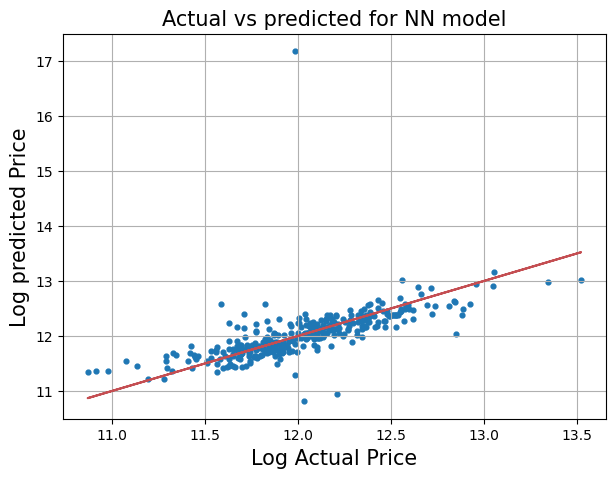

In [19]:

# Slecting fewer features for NN
dev_train_NN = standard_feature_eng(na_clean(train))[['LotArea', 'OverallQual','Remodeled', 
                          'Total_Inside_Area', 'Bathrooms','LogSalePrice']][:1120]
dev_test_NN = standard_feature_eng(na_clean(train))[['LotArea', 'OverallQual','Remodeled', 
                          'Total_Inside_Area', 'Bathrooms', 'LogSalePrice']][1120:]

# Splitting the dataset into the Training set and Test set
X_train = dev_train_NN.drop(columns = ['LogSalePrice'])
X_test = dev_test_NN.drop(columns = ['LogSalePrice'])
y_train = dev_train_NN.LogSalePrice
y_test = dev_test_NN.LogSalePrice

# Feature Scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# having 5 neuron is based on the number of available features
model = Sequential()
model.add(Dense(5,activation='relu'))
model.add(Dense(5,activation='relu'))
model.add(Dense(5,activation='relu'))
model.add(Dense(5,activation='relu'))
model.add(Dense(1))

# Compiling the ANN
model.compile(optimizer='Adam',loss='mean_squared_error')

# Fitting the ANN to the Training set
model.fit(x=X_train,y=y_train,
          validation_data=(X_test,y_test),
          batch_size=128,epochs=400, verbose=0)


# Evaluate the NN
y_pred = model.predict(X_test) 
print('Log RMSE for Neural Network:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


# Plot
fig = plt.figure(figsize = (7,5))
ax = fig.add_subplot(1,1,1)

# Visualizing Our predictions
ax.scatter(y_test,y_pred, s = 12)
# Perfect predictions
ax.plot(y_test,y_test,'r')


ax.set_xlabel('Log Actual Price', fontsize = 15)
ax.set_ylabel('Log predicted Price', fontsize = 15)
ax.set_title('Actual vs predicted for NN model', fontsize = 15)
ax.grid()

# Final Model

Our final model uses an ensemble of five different regression models: an OLS model with 16 variables, a simple OLS model with one variable, Lasso regression, random forest, and XGBoost. Below, we describe how we build each one. 

## OLS

The inclusion of the simple OLS model in our ensemble is one of the more baffling results of tests of our various model configurations. Its original inclusion in the ensemble model was a simple thought experiment about whether or not our original OLS model contained too many variables, and whether including an OLS model with only a single variable (the single strongest corollary with sale price, the assessed overall quality of the property), improved the fit over the more inclusive OLS regression. The result was, to our surprise, that the simple OLS model, as we dubbed it, performed somewhat better than our inclusive OLS. We then tried to adjust the variables included in the OLS regression but for whatever reason even an OLS model with just the two most correlated variables (assessed overall property quality and the square footage of the home) performed worse than the one-variable simple OLS. It should be said that these quality of fits were measured in conjunction with the other models included in the final ensemble and not on their own. It’s not entirely known to us why the inclusion of the simple OLS improves the overall fit so well compared to the more logical inclusive OLS model. It could be that the other models with heavier weights such as random forest and lasso regression are overly complex and overfit the training data. By comparison, simple OLS has an extremely poor fit on training data and perhaps its small weight somewhat improves the overall model by reducing this degree of overfitting. In contrast the more inclusive OLS could be more overfit while also being an inferior predictor compared to Lasso and Random Forest hence why its inclusion actually reduced our ensemble model’s overall performance. 

In [20]:
def lm_df_clean(df, test_data = False):

    # first run standard data cleaning steps
    df = na_clean(df)
    df = standard_feature_eng(df, test_data = test_data)

    lm_vars = ['LotArea', 'Street', 'Neighborhood', 'OverallQual', 'OverallCond', 'YearRemodAdd', 
              'BsmtCond', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'YrSold', 
             'MoSold', 'Remodeled', 'Total_Inside_Area', 'Bathrooms', 'GarageCars', 'BsmtFinSF1']
    
    df = pd.get_dummies(df[lm_vars], 
        columns = ['Street', 'Neighborhood', 'OverallQual', 'OverallCond', 'BsmtCond','KitchenQual'], 
        drop_first=True)

    return df


# data setups
X_train = lm_df_clean(train)
X_test = lm_df_clean(test, test_data=True)
Y_train = train.SalePrice
Y_test = sample.SalePrice

# fit to train data
lr_1 = LinearRegression(fit_intercept=True).fit(X_train, Y_train)

# evaluate performance
print("Score on training data: {:.3f}".format(lr_1.score(X_train,Y_train)))
print("Score on testing data: {:.3f}".format(lr_1.score(X_test ,Y_test)))

yhat_train = lr_1.predict(X_train)
yhat_test = lr_1.predict(X_test)

# rmse
rmse_train = (np.mean((np.log(yhat_train) - np.log(Y_train))**2))**.5
rmse_test = (np.mean((np.log(yhat_test) - np.log(Y_test))**2))**.5

print("Log RMSE on training data: {:.3f}".format(rmse_train))
print("Log RMSE on testing data: {:.3f}".format(rmse_test))

Score on training data: 0.859
Score on testing data: -17.901
Log RMSE on training data: 0.141
Log RMSE on testing data: 0.388


An OLS model that only uses the overall quality variable.

In [21]:
# data setup function
def lm_overall_quality_df_clean(df, test_data = False):

    # first run standard data cleaning steps
    df = na_clean(df)
    df = standard_feature_eng(df, test_data = test_data)
    df = df.loc[:, ['OverallQual']]
    
    return df

# data setups
X_train = lm_overall_quality_df_clean(train)
X_test = lm_overall_quality_df_clean(test, test_data=True)
Y_train = train.SalePrice
Y_test = sample.SalePrice

# fit to train data
lr_overall_quality = LinearRegression(fit_intercept=True).fit(X_train, Y_train)

# Evaluate performance
print("Score on training data: {:.3f}".format(lr_overall_quality.score(X_train,Y_train)))
print("Score on testing data: {:.3f}".format(lr_overall_quality.score(X_test ,Y_test)))

yhat_train = lr_overall_quality.predict(X_train)
yhat_test = lr_overall_quality.predict(X_test)

# set negative values to 0.1
yhat_train = np.array([0.1 if i < 0 else i for i in yhat_train])
yhat_test = [0.1 if i < 0 else i for i in yhat_test]

# rmse
rmse_train = (np.mean((np.log(yhat_train) - np.log(Y_train))**2))**.5
rmse_test = (np.mean((np.log(yhat_test) - np.log(Y_test))**2))**.5

print("Log RMSE on training data: {:.3f}".format(rmse_train))
print("Log RMSE on testing data: {:.3f}".format(rmse_test))

Score on training data: 0.626
Score on testing data: -14.882
Log RMSE on training data: 0.811
Log RMSE on testing data: 1.354


## Lasso

When we first started this project, our team began by looking over quite a few Kaggle submissions that had previously been successful for this particular problem. Early on, it became apparent that one of the most common models employed by previously successful teams was the lasso regression. There are two major benefits of lasso regression over standard OLS for this particular problem. For one, lasso regression does not assume there is no collinearity between the variables in the model. From the very first round of EDA that we conducted, we learned that many of the variables in the dataset are highly correlated including many of the ones which were most correlated with sale price in preliminary tests (for instance the square footage of the lot and the square footage of the house, or overall assessed quality of the property and assessed quality of the kitchen alone). The second major benefit of using lasso regression is it minimizes the amount of feature selection we need to do, as lasso regression can assign weights of 0 to variables that are poorly correlated with the outcome variable. The final dataset we fit through our model has over a hundred variables as we divided up some string categorical variables into binary boolean variables for each possible category, expanding the size of the dataset significantly. These are likely the reasons why Lasso was the best performing of all of the four models that were employed in the final ensemble, and why its weight ended up being so high in the ensemble model. 

However there are still some drawbacks to Lasso regression, particularly its assumption of homoscedasticity of the data. There were around 10 variables that had wide ranges of values and appeared to be particularly heteroscedastic, mostly square footage variables and the sale price of the houses themselves. While the sale price was log-transformed for all models, three additional variables were log-transformed for the lasso regression to more strongly satisfy the homoscedasticity assumption and improve its fit: Basement square footage, lot area square footage, and basement square footage. All of the potential candidates were tested and while performing log transformations on most of them did not make the model significantly worse, only those which decreased RMSE on the testing data were kept in the final model.  

Further improvements to the lasso regression’s fit were teased out by changing the alpha hyperparameter. Based on a series of experiments it became apparent that lower alpha values generally caused the fit of the model to improve, hence why the final alpha value is a very low 0.000001.

In [22]:
# first build one hot encoder based on the training data
train_lasso = standard_feature_eng(na_clean(train))
enc_lasso = OneHotEncoder(handle_unknown = 'ignore')
enc_lasso.fit(train_lasso.select_dtypes(include=["object"]))
one_hot_columns = pd.get_dummies(train_lasso.select_dtypes(include=["object"])).columns
# will use this encoder in the function below

# data setup function
def lasso_df_clean(df, test_data = False):

    # first run standard data cleaning steps
    df = na_clean(df)
    
    df = standard_feature_eng(df, test_data = test_data)
    
    # one hot encode using encoder above
    categorical_cols = pd.DataFrame(enc_lasso.transform(df.select_dtypes(include=["object"])).toarray())
    
    categorical_cols.columns = one_hot_columns
    
    df = df.reset_index().drop(columns='index')
    categorical_cols = categorical_cols.reset_index().drop(columns='index')
    
    df = pd.concat([categorical_cols, df.select_dtypes(exclude=["object"])], axis=1)
    
    # log transformations
    #df["GrLivArea"] = np.log(df["GrLivArea"])
    df.Total_Inside_Area = np.log(df.Total_Inside_Area)
    df.LotArea = np.log(df.LotArea)
    for x in range(len(df.BsmtFinSF1)):
        if df['BsmtFinSF1'][x] ==0:
            df['BsmtFinSF1'][x] = 1
    df.BsmtFinSF1 = np.log(df.BsmtFinSF1)
    
    # select only vars needed
    if test_data:
        df = df.drop(columns=["Id"])
    else:
        df = df.drop(columns=["Id"])
        df['SalePrice'] = np.log(df['SalePrice'])
    
    return df


# data setups
X_train = lasso_df_clean(train)
X_test = lasso_df_clean(test, test_data=True)
Y_train = X_train.SalePrice
X_train = X_train.drop(columns=['LogSalePrice', 'SalePrice'])
Y_test = np.log(sample.SalePrice)


# fit to train data
lasso_fit = Lasso(alpha=0.000001).fit(X_train, Y_train)


# Evaluate performance
yhat_train = lasso_fit.predict(X_train)
yhat_test = lasso_fit.predict(X_test)

# Evaluate performance
print("Score on training data: {:.3f}".format(lasso_fit.score(X_train,Y_train)))
print("Score on testing data: {:.3f}".format(lasso_fit.score(X_test ,Y_test)))

# rmse
rmse_train = (np.mean((yhat_train - np.log(train.SalePrice))**2))**.5
rmse_test = (np.mean((yhat_test - np.log(sample.SalePrice))**2))**.5

print("Log RMSE on training data: {:.3f}".format(rmse_train))
print("Log RMSE on testing data: {:.3f}".format(rmse_test))

Score on training data: 0.930
Score on testing data: -17.705
Log RMSE on training data: 0.105
Log RMSE on testing data: 0.389


C:\Users\drkul\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.445084072788501, tolerance: 0.02328006589886511
  model = cd_fast.enet_coordinate_descent(


## Random Forest

Next, we built a random forest regression model using every variable. After performing cross validation and trying out many different hyperparameter options, the options below were selected. It seems the model with fairly deep trees (25 max depth), very granular splits requiring a minimum of 2 observations to create another split, and 900 tree estimators returned the best accuracy.

The plot below shows the variables used most often in the 900 decision trees. Overall quality, total inside square footage, the number of bathrooms, and garage size were among the most used variables to predict sale price. 

In [23]:
# first build one hot encoder based on the training data
train_rf = standard_feature_eng(na_clean(train))
enc_rf = OneHotEncoder(handle_unknown = 'ignore')
enc_rf.fit(train_rf.select_dtypes(include=["object"]))
one_hot_columns = pd.get_dummies(train_rf.select_dtypes(include=["object"])).columns
# will use this encoder in the function below

# Random forest data clean function
def rf_df_clean(df, test_data = False):

    # first run standard data cleaning steps
    df = na_clean(df)
    df = standard_feature_eng(df, test_data = test_data)

    # one hot encode using encoder above
    categorical_cols = pd.DataFrame(enc_rf.transform(df.select_dtypes(include=["object"])).toarray())
    categorical_cols.columns = one_hot_columns
    
    df = df.reset_index().drop(columns='index')
    categorical_cols = categorical_cols.reset_index().drop(columns='index')
    
    df = pd.concat([categorical_cols, df.select_dtypes(exclude=["object"])], axis=1)
    
    # drop irrelevant columns
    df = df.drop(columns=["Id"])
    
    return df


# preprocess the data
df_rf = rf_df_clean(train)
df_rf_test = rf_df_clean(test, test_data=True)

# run model on best parameters
rf_reg = RandomForestRegressor(
    n_estimators = 900,
    max_depth = 25,
    max_features = 'auto',
    min_samples_split = 2,  
    bootstrap = True, 
    )

# fit the model
rf_reg = rf_reg.fit(df_rf.drop(columns = ["SalePrice", 'LogSalePrice']), df_rf.LogSalePrice)

# Evaluate performance
yhat_train = rf_reg.predict(df_rf.drop(columns = ["SalePrice", 'LogSalePrice']))
yhat_test = rf_reg.predict(df_rf_test)

# Evaluate performance
print("Score on training data: {:.3f}".format(rf_reg.score(df_rf.drop(columns = ["SalePrice", 'LogSalePrice']), df_rf.LogSalePrice)))
print("Score on testing data: {:.3f}".format(rf_reg.score(df_rf_test, np.log(sample.SalePrice))))

# rmse
rmse_train = (np.mean((yhat_train - np.log(train.SalePrice))**2))**.5
rmse_test = (np.mean((yhat_test - np.log(sample.SalePrice))**2))**.5

print("Log RMSE on training data: {:.3f}".format(rmse_train))
print("Log RMSE on testing data: {:.3f}".format(rmse_test))

Score on training data: 0.983
Score on testing data: -15.400
Log RMSE on training data: 0.052
Log RMSE on testing data: 0.365


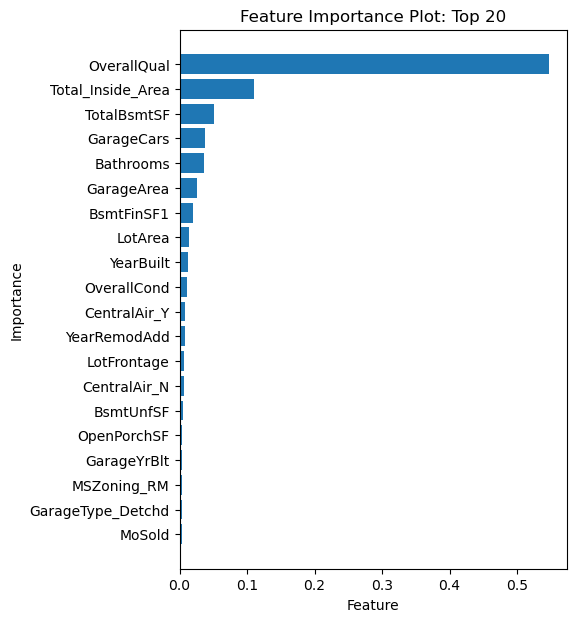

In [24]:
# variable importance plot
var_imp = pd.DataFrame({
    'feature': df_rf.drop(columns = ["SalePrice", 'LogSalePrice']).columns,
    'importance': rf_reg.feature_importances_
})
var_imp.sort_values("importance", ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(5, 7))
topn = 20
ax.barh(var_imp.head(topn).feature, var_imp.head(topn).importance)
ax.set_ylabel("Importance")
ax.set_xlabel("Feature")
ax.set_title("Feature Importance Plot: Top {}".format(topn))
ax.invert_yaxis()
print("")


## XGBoost

The final model used in our ensemble is an extreme gradient boosted regression tree model (XGBoost). Like the random forest, XGBoost picks up interaction effects between variables automatically, and performs a form of feature selection on its own. XGBoost is more prone to overfit than the random forest due to fitting iterative trees on residuals from the previous tree, but as a trade off this model can produce high predictive accuracy.

After hyperparameter tuning, some of the hyperparameters we found to produce the best results were to use 50% of the training observations and 70% of the training features in each boosted tree build, 500 ensemble trees in the forest with a max depth of 20, a .05 learning rate, and L1 and L2 regularization strengths of .01 and .1.

XGBoost's variable importance plot shows that XGBoost also used overall quality the most frequently. It also found that exterior quality, garage car size, and total inside area to be used most frequently in the splits. 

In [25]:
# first build one hot encoder based on the training data
train_xgb = standard_feature_eng(na_clean(train))
enc_xgb = OneHotEncoder(handle_unknown = 'ignore')
enc_xgb.fit(train_xgb.select_dtypes(include=["object"]))
one_hot_columns_xgb = pd.get_dummies(train_xgb.select_dtypes(include=["object"])).columns
# will use this encoder in the function below

# xgboost data clean function
def xgb_df_clean(df, test_data = False):

    # first run standard data cleaning steps
    df = na_clean(df)
    df = standard_feature_eng(df, test_data = test_data)

    # one hot encode using encoder above
    categorical_cols = pd.DataFrame(enc_xgb.transform(df.select_dtypes(include=["object"])).toarray())
    categorical_cols.columns = one_hot_columns_xgb
    
    #df = df.reset_index().drop(columns='index')
    #categorical_cols = categorical_cols.reset_index().drop(columns='index')
    
    df = pd.concat([categorical_cols, df.select_dtypes(exclude=["object"])], axis=1)
    
    # DO MORE FEATURE ENGINEERING HERE LATER
    df = df.drop(columns = ['Id'])
    
    return df


# preprocess the data
df_xgb = xgb_df_clean(train)
df_xgb_test = xgb_df_clean(test, test_data=True)

# final hyper params
xgb_reg = xgb.XGBRegressor(
    booster="gbtree",
    verbosity=0,
    subsample=.5,  
    colsample_bytree=.7, 
    random_state=1,

    n_estimators=500, 
    max_depth=20,
    learning_rate=.05, 
    reg_alpha=.01, 
    reg_lambda=0.1
)

# fit model
xgb_reg.fit(df_xgb.drop(columns=['SalePrice', 'LogSalePrice']), df_xgb['LogSalePrice'])

# performance on train/test
yhat_train = xgb_reg.predict(df_xgb.drop(columns = ["SalePrice", 'LogSalePrice']))
yhat_test = xgb_reg.predict(df_xgb_test)

# Evaluate performance
print("Score on training data: {:.3f}".format(xgb_reg.score(df_xgb.drop(columns = ["SalePrice", 'LogSalePrice']), df_xgb.LogSalePrice)))
print("Score on testing data: {:.3f}".format(xgb_reg.score(df_xgb_test, np.log(sample.SalePrice))))

# rmse
rmse_train = (np.mean((yhat_train - np.log(train.SalePrice))**2))**.5
rmse_test = (np.mean((yhat_test - np.log(sample.SalePrice))**2))**.5

print("Log RMSE on training data: {:.3f}".format(rmse_train))
print("Log RMSE on testing data: {:.3f}".format(rmse_test))

Score on training data: 1.000
Score on testing data: -17.891
Log RMSE on training data: 0.001
Log RMSE on testing data: 0.391


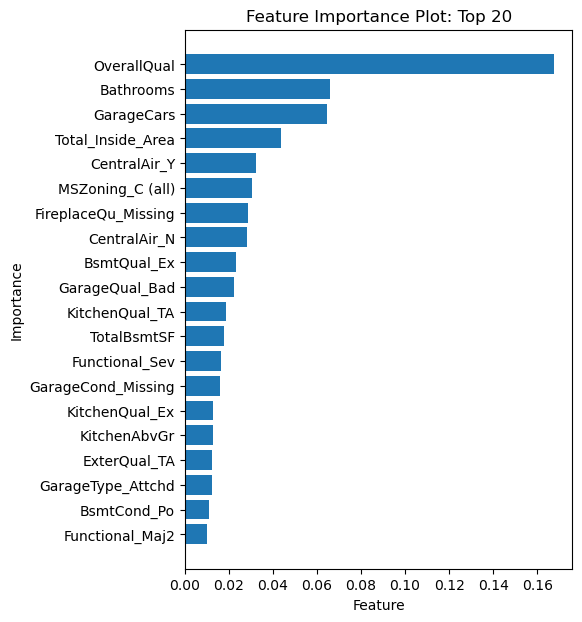

In [26]:
# variable importance plot
var_imp = pd.DataFrame({
    'feature': df_xgb.drop(columns = ["SalePrice", 'LogSalePrice']).columns,
    'importance': xgb_reg.feature_importances_
})
var_imp.sort_values("importance", ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(5, 7))
topn = 20
ax.barh(var_imp.head(topn).feature, var_imp.head(topn).importance)
ax.set_ylabel("Importance")
ax.set_xlabel("Feature")
ax.set_title("Feature Importance Plot: Top {}".format(topn))
ax.invert_yaxis()
print("")


## Ensemble Weights and Final Model Assembly

This section is where all of the previously shown models are combined into a single ensemble model. Essentially all of the models generate predicted outputs in terms of log of sale price for the test data, so all of these outputs are then raised as powers of e to convert them back to untransformed sale prices. Then each of the predicted sale prices for each model are then multiplied by a weight to combine all of the model results into a final prediction. It was not immediately clear to the team which combination of models would produce the best results. Initially all five models: Inclusive OLS, Simple OLS, Lasso, Random Forest, and Boosted Trees, were all given equal weight. Over 50 different combinations of weights were tested before we settled on this final configuration which produced the most optimal results. Deciding which models to give which weights eventually became a game of guess and check after some time. The RMSE on both train and test were poor predictors of which configuration of models would perform the best on the unseen test data. The following is a plot of some of these configurations’ RSME on the train data and test data compared to the unseen test data that the Kaggle score was assessed on:

<img src="../images/rmse_train.png" alt="rmse_train" width="50%" height="50%">

<img src="../images/rmse_test.png" alt="rmse_test" width="50%" height="50%">

The final configuration with the best results consisted of the following weights:

- Simple OLS: 7.5%
- Lasso: 57.5%
- Random Forest: 30%
- XGBoost: 5%

It’s difficult to know exactly why this configuration is the best. As stated previously in each of their respective sections, there are pros and cons to each model, and it’s likely that for whatever reason this system of weights produces the best results by counterbalancing each of these various pros and cons. As stated previously Lasso is likely the best fit and consequently the heaviest weight because of the lack of a no collinearity assumption and the fact that it can filter out less helpful variables by allowing weights of variables to go to 0. The Random Forest model and XGBoost model likely had value due to their ability to calculate the interactions between each of the variables and perform automatic estimations of the best feature selections. The lack of assumptions about the data in terms of collinearity likely improved their value over traditional OLS. The value of the simple OLS model is less clear, the best theory is that the overall model overfits to such a degree that allocating some weight to a model that severely underfits improves the overall fit of the model.

In [27]:
def housing_ensemble_model(df, output_type='regular'):
    '''This is the final model that takes in raw data, and makes predictions'''

    # OLS
    yhat_ols1 = lr_1.predict(lm_df_clean(df, test_data=True))

    # OLS Simple
    yhat_ols_simple = lr_overall_quality.predict(lm_overall_quality_df_clean(df, test_data=True))

    # GLM

    # Lasso
    lasso_data = lasso_df_clean(df, test_data=True)
    yhat_lasso = np.exp(lasso_fit.predict(lasso_data))

    # Random forest
    yhat_rf = np.exp(rf_reg.predict(rf_df_clean(df, test_data=True)))

    # XGB
    xgb_data = xgb_df_clean(df, test_data=True)
    yhat_xgb = np.exp(xgb_reg.predict(xgb_data))

    # make ensemble prediction
    # Do more work to come up w/ weights. This is just a sample
    yhat_final = yhat_lasso
    for i in range(len(yhat_lasso)):    
        if yhat_lasso[i] < 200000:

            yhat_final[i] = yhat_ols_simple[i] * (0.075) + yhat_lasso[i] * (0.575) + yhat_rf[i] * (0.3) + yhat_xgb[i] * (0.05)

        elif yhat_lasso[i] >= 200000 and yhat_lasso[i] < 400000:

            yhat_final[i] = yhat_ols_simple[i] * (0.075) + yhat_lasso[i] * (0.575) + yhat_rf[i] * (0.3) + yhat_xgb[i] * (0.07)

        else:

            yhat_final[i] = yhat_ols_simple[i] * (0.075) + yhat_lasso[i] * (0.575) + yhat_rf[i] * (0.3) + yhat_xgb[i] * (0.05)
    
    if output_type == "regular":

        return yhat_final
    
    elif output_type == "df":
        result_df = pd.DataFrame({
            "ols1":          yhat_ols1, 
            "ols_simple":    yhat_ols_simple, 
            "lasso":         yhat_lasso, 
            "random_forest": yhat_rf, 
            "xgb":           yhat_xgb, 
            "ensemble":      yhat_final
        })
        return result_df
    
    else:
        return yhat_final



# final ensemble model RMSE
yhat_train = housing_ensemble_model(train.drop(columns = ["SalePrice"]))
yhat_test = housing_ensemble_model(test)

rmse_train = np.mean((train.SalePrice - yhat_train)**2)**.5
rmse_test = np.mean((sample.SalePrice - yhat_test)**2)**.5

# evaluate rmse  on the testing data
print("RMSE Train: {:.2f}".format(rmse_train))
print("RMSE Test: {:.2f}".format(rmse_test))

# log results
rmse_train_log = np.mean((np.log(train.SalePrice) - np.log(yhat_train))**2)**.5
rmse_test_log = np.mean((np.log(sample.SalePrice) - np.log(yhat_test))**2)**.5
# evaluate rmse  on the testing data
print("\nLog RMSE Train: {:.5f}".format(rmse_train_log))
print("Log RMSE Test: {:.5f}".format(rmse_test_log))

RMSE Train: 17997.81
RMSE Test: 72146.46

Log RMSE Train: 0.08386
Log RMSE Test: 0.37973


Kaggle Score: 0.12301

Rank: 558 / 4770 = 11.69%

Comparing predictions to actual results. 

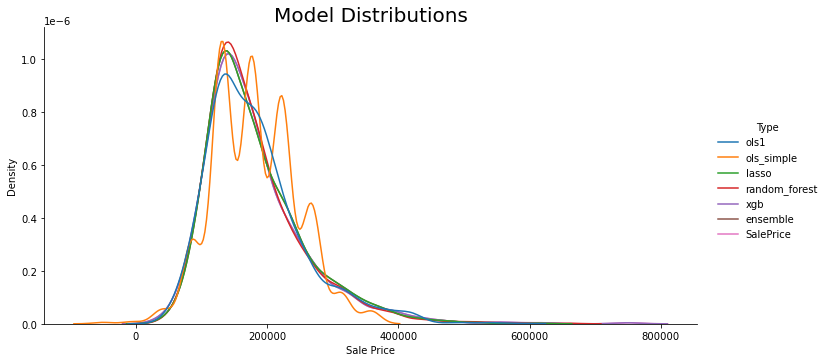

In [28]:
results_df = housing_ensemble_model(train.drop(columns = ["SalePrice"]), output_type="df")
results_df['SalePrice'] = standard_feature_eng(na_clean(train))['SalePrice']
results_df = results_df.melt(var_name="Type", value_name="saleprice")

sns.reset_orig()
sns.displot(results_df, x="saleprice", hue="Type", kind="kde", aspect=2).set_axis_labels(x_var="Sale Price")
plt.title("Model Distributions",fontdict={"fontsize": 20})
print("")

More Comparison of Predictions with Actual Results

## Conclusion

Scoring the output of our final model on Kaggle, we received an RMSE of 0.12328. Kaggle uses a 2-month rolling leaderboard for this open competition, and this score put us into a position of 654 out of 4917 active competitors.  Based on that ranking, we feel that while we have created a strong model, there is clearly some room for improvement.  

The process highlighted some very important steps for creating a model that performs well on this type of complex data set.  

* For one, it is important to have a good understanding of the data itself.  A thorough EDA allowed us to understand and eliminate variables with a strong colinearity.  It also allowed us to transform variables into something more useful, such as aggregating all of the square footage values, or simple log transformations for a more normal distribution. We spent a lot of time exploring which variables led to valuable insights into the data.  Some were surprising, such as a subjective measure like Overall Quality.  

* Second, we went down a lot of paths that ended up not bearing fruit.  For example, we explored pre-modeling the neighborhoods into various divisions of expensive and inexpensive, but were unable to get this to lead to any measurable improvement ino the final result.  We also toyed with a lot of data transformations that were ultimately ineffective. However, the explorations were necessary and worthwhile since we needed to answer those questions to move forward.  

* There were many iterations of fine-tuning the final ensemble model with the right weights of each model.  In our experience the right balance was not intuitive, and really just came down to a lot of trial-and-error.  However, this trial-and-error process did ultimately make some of our most significant gains in performance as we narrowed down to our final RMSE score.


[not complete yet]